In [1]:
!pip install --quiet pandas boto3 matplotlib seaborn

In [2]:
import time
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Your AWS Athena Details ---
ATHENA_DATABASE = 'nyc_taxi_db'
ATHENA_WORKGROUP = 'analytics'
S3_OUTPUT_LOCATION = 's3://nyc-taxi-processed-data-project-c998f766425640a0/athena-query-results/'

# Set a nice visual theme for our charts
sns.set_theme(style="whitegrid")

In [3]:
def run_athena_query(query):
    """Executes an Athena query and returns the results as a pandas DataFrame."""
    # --- THIS IS THE UPDATED LINE ---
    # We explicitly set the region to ensure we connect to the correct one.
    client = boto3.client('athena', region_name='us-east-1')
    
    response = client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={'Database': ATHENA_DATABASE},
        ResultConfiguration={'OutputLocation': S3_OUTPUT_LOCATION},
        WorkGroup=ATHENA_WORKGROUP
    )
    
    query_execution_id = response['QueryExecutionId']
    
    # Wait for the query to complete
    while True:
        stats = client.get_query_execution(QueryExecutionId=query_execution_id)
        status = stats['QueryExecution']['Status']['State']
        if status in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
            break
        time.sleep(1) # Wait 1 second before checking again

    if status != 'SUCCEEDED':
        raise Exception(f"Query failed: {stats['QueryExecution']['Status']['StateChangeReason']}")
        
    # Get the results
    results_paginator = client.get_paginator('get_query_results')
    results_iter = results_paginator.paginate(
        QueryExecutionId=query_execution_id,
        PaginationConfig={'PageSize': 1000}
    )
    
    # Process results into a DataFrame
    rows = []
    column_names = []
    for i, results_page in enumerate(results_iter):
        # Get column names from the first page
        if i == 0:
            column_names = [col['Name'] for col in results_page['ResultSet']['ResultSetMetadata']['ColumnInfo']]
        # Skip header row
        for row in results_page['ResultSet']['Rows'][1 if i == 0 else 0:]:
            rows.append([d.get('VarCharValue') for d in row['Data']])
            
    return pd.DataFrame(rows, columns=column_names)


Running Hotspots Query...
Query complete. Plotting results...


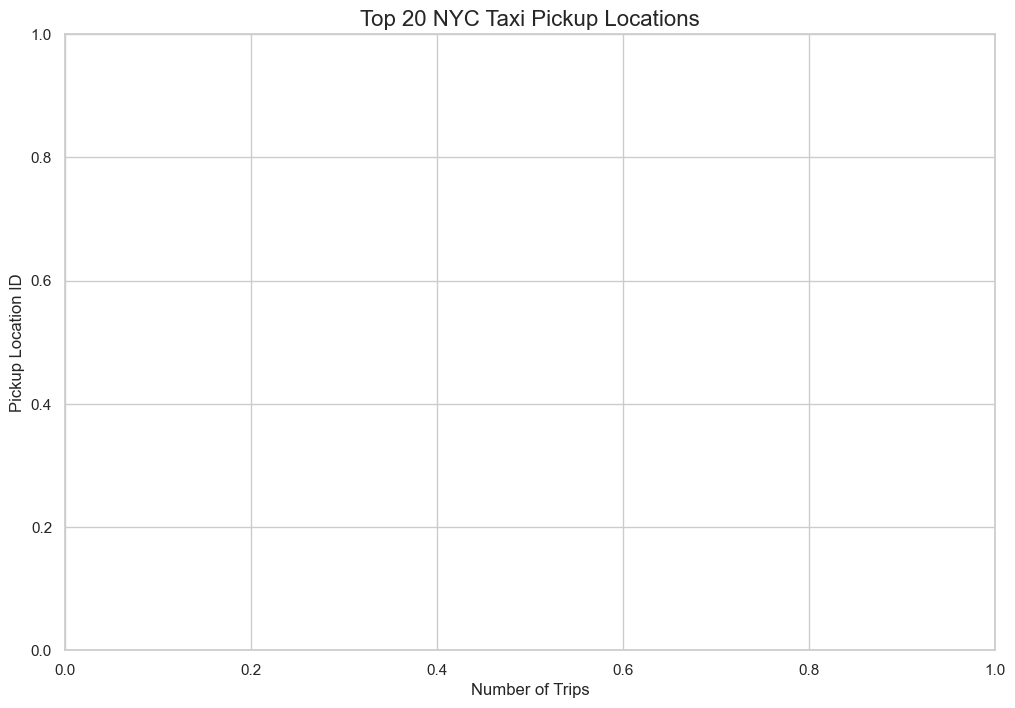

In [4]:
query1 = """
SELECT
  "PULocationID",
  COUNT(*) AS number_of_trips
FROM "nyc_taxi_db"."processed_taxi_trips"
WHERE "PULocationID" IS NOT NULL 
  AND "PULocationID" NOT IN (264, 265) -- Filter out 'N/A' and 'Unknown'
GROUP BY "PULocationID"
ORDER BY number_of_trips DESC
LIMIT 20;
"""

print("Running Hotspots Query...")
df_hotspots = run_athena_query(query1)
print("Query complete. Plotting results...")

# Convert data types for plotting
df_hotspots['PULocationID'] = df_hotspots['PULocationID'].astype(str)
df_hotspots['number_of_trips'] = df_hotspots['number_of_trips'].astype(int)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=df_hotspots, x='number_of_trips', y='PULocationID', orient='h')
plt.title('Top 20 NYC Taxi Pickup Locations', fontsize=16)
plt.xlabel('Number of Trips', fontsize=12)
plt.ylabel('Pickup Location ID', fontsize=12)
plt.show()


In [ ]:
query2 = """
SELECT
  CASE
    WHEN fare_amount BETWEEN 0 AND 5 THEN '1. $0-5'
    WHEN fare_amount BETWEEN 5.01 AND 10 THEN '2. $5-10'
    WHEN fare_amount BETWEEN 10.01 AND 20 THEN '3. $10-20'
    WHEN fare_amount BETWEEN 20.01 AND 40 THEN '4. $20-40'
    ELSE '5. $40+'
  END AS fare_bracket,
  COUNT(*) AS number_of_trips
FROM "nyc_taxi_db"."processed_taxi_trips"
GROUP BY 1
ORDER BY 1;
"""

print("Running Fare Distribution Query...")
df_fares = run_athena_query(query2)
print("Query complete. Plotting results...")

# Convert data type
df_fares['number_of_trips'] = df_fares['number_of_trips'].astype(int)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_fares, x='fare_bracket', y='number_of_trips')
plt.title('Distribution of Taxi Fare Amounts', fontsize=16)
plt.xlabel('Fare Bracket', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.show()


In [ ]:
query3 = """
SELECT
  EXTRACT(hour FROM tpep_pickup_datetime) AS hour_of_day,
  AVG(trip_duration_minutes) AS avg_duration
FROM "nyc_taxi_db"."processed_taxi_trips"
GROUP BY 1
ORDER BY 1;
"""

print("Running Trip Duration Query...")
df_duration = run_athena_query(query3)
print("Query complete. Plotting results...")


# Convert data types
df_duration['hour_of_day'] = df_duration['hour_of_day'].astype(int)
df_duration['avg_duration'] = df_duration['avg_duration'].astype(float).round(2)

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_duration, x='hour_of_day', y='avg_duration', marker='o')
plt.title('Average Trip Duration by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Average Duration (Minutes)', fontsize=12)
plt.xticks(range(0, 24))
plt.show()

In [ ]:
query4 = """
SELECT
  CASE 
    WHEN pulocationid IS NULL OR pulocationid IN (264, 265) THEN 'Invalid/Unknown ID'
    ELSE 'Valid ID'
  END AS id_status,
  COUNT(*) as number_of_trips
FROM "nyc_taxi_db"."processed_taxi_trips"
GROUP BY 1
"""

print("Running Data Quality Query...")
df_quality = run_athena_query(query4)
print("Query complete. Plotting results...")

# Convert data type
df_quality['number_of_trips'] = df_quality['number_of_trips'].astype(int)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(df_quality['number_of_trips'], 
        labels=df_quality['id_status'], 
        autopct='%1.1f%%', 
        startangle=90, 
        textprops={'fontsize': 14})
plt.title('Distribution of Valid vs. Invalid Pickup Location IDs', fontsize=16)
plt.show()